In [0]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [0]:
import tensorflow_hub as hub

In [4]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
train=mnist.train.images[:]
train.shape

(55000, 784)

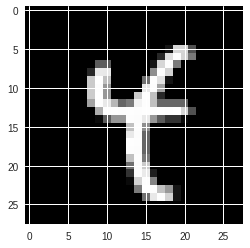

In [6]:
randomNumber=random.randint(0,55000)
image=train[randomNumber].reshape([28,28])
plt.imshow(image,cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
def conv2D(x,W):
  return tf.nn.conv2d(input=x,filter=W,strides=[1,1,1,1],padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


In [0]:
def discreminator(x_image,reuse=False):
  with tf.variable_scope('discreminator') as scope:
    if (reuse):
      tf.get_variable_scope().reuse_variables()
      
    w_conv1=tf.get_variable('d_wconv1',[5,5,1,8],initializer=tf.truncated_normal_initializer(stddev=0.02))
    #The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels
    b_conv1=tf.get_variable('d_bconv1',[8],initializer=tf.constant_initializer(0))
    h_conv1=tf.nn.leaky_relu(conv2D(x_image,w_conv1)+b_conv1)
    h_pool1=avg_pool_2x2(h_conv1)
    #relu is a max(0,x) function. If there is any input -ve on the input(eg: black in image), it sets to 0
    #h_pool1 pools the avegae of 4 variables to one for better generalization of the image
    
    #second layer
    
    w_conv2=tf.get_variable('d_wconv2',[5,5,8,16],initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_conv2=tf.get_variable('d_bconv2',[16],initializer=tf.constant_initializer(0))
    h_conv2=tf.nn.leaky_relu(conv2D(h_pool1,w_conv2)+b_conv2)
    h_pool2=avg_pool_2x2(h_conv2)
    
    #first fully connected layer
    
    w_fc1=tf.get_variable('d_wfc1',[7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc1=tf.get_variable('d_bfc1',[32],initializer=tf.constant_initializer(0))
    h_pool2_flat= tf.reshape(h_pool2,[-1, 7*7*16])
    h_fc1=tf.nn.leaky_relu(tf.matmul(h_pool2_flat,w_fc1)+b_fc1)
    print(h_fc1.shape)
    
    
    w_fc2 = tf.get_variable('d_wfc2', [32,1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))
    
    y_conv=tf.matmul(h_fc1,w_fc2)+b_fc2
    
    
   
  return y_conv
    
    

In [0]:
def generator(z,batch_size,z_dim,reuse=False):
  with tf.variable_scope('generator') as scope:
    if (reuse):
      tf.get_variable_scope().reuse_variables()
      
    g_dim=64
    c_dim=1
    s=28
    
    
    s2,s4,s8,s16=int(s/2),int(s/4),int(s/8),int(s/16)
    h0=tf.reshape(z,[batch_size,s16+1,s16+1,25])
    h0=tf.nn.relu(h0)
    
    #First deconv layer
    
    output1_shape=[batch_size,s8,s8,g_dim*4]
    w_conv1=tf.get_variable('g_wconv1',[5,5,output1_shape[-1],int(h0.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1=tf.get_variable('g_bconv1',[output1_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv1=tf.nn.conv2d_transpose(h0,w_conv1,output_shape=output1_shape,strides=[1,2,2,1],padding='SAME')+b_conv1
    h_conv1=tf.contrib.layers.batch_norm(inputs=h_conv1,center=True,scale=True,is_training=True,scope='g_bn1')
    h_conv1=tf.nn.leaky_relu(h_conv1)
    #Dimensions of H_conv1 = batch_size x 3 x 3 x 256
    
    
    output2_shape=[batch_size,s4-1,s4-1,g_dim*2]
    w_conv2=tf.get_variable('g_wconv2',[5,5,output2_shape[-1],int(h_conv1.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    b_conv2=tf.get_variable('g_bconv2',[output2_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv2=tf.nn.conv2d_transpose(h_conv1,w_conv2,output_shape=output2_shape,strides=[1,2,2,1],padding='SAME')+b_conv2
    h_conv2=tf.contrib.layers.batch_norm(inputs=h_conv2,center=True,scale=True,is_training=True,scope='g_bn2')
    h_conv2=tf.nn.leaky_relu(h_conv2)
    #Dimensions of H_conv2 = batch_size x 6 x 6 x 128
    
    
    output3_shape=[batch_size,s2-2,s2-2,g_dim*1]
    w_conv3=tf.get_variable('g_wconv3',[5,5,output3_shape[-1],int(h_conv2.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    print(w_conv3.shape)
    
    b_conv3=tf.get_variable('g_bconv3',[output3_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv3=tf.nn.conv2d_transpose(h_conv2,w_conv3,output_shape=output3_shape,strides=[1,2,2,1],padding='SAME')+b_conv3
    h_conv3=tf.contrib.layers.batch_norm(inputs=h_conv3,center=True,scale=True,is_training=True,scope='g_bn3')
    h_conv3=tf.nn.leaky_relu(h_conv3)
    ##Dimensions of H_conv3 = batch_size x 12 x 12 x 64
    
    
    output4_shape=[batch_size,s,s,c_dim]
    w_conv4=tf.get_variable('g_wconv4',[5,5,output4_shape[-1],int(h_conv3.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    b_conv4=tf.get_variable('g_bconv4',[output4_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv4=tf.nn.conv2d_transpose(h_conv3,w_conv4,output_shape=output4_shape,strides=[1,2,2,1],padding='VALID')+b_conv4
    h_conv4=tf.contrib.layers.batch_norm(inputs=h_conv4,center=True,scale=True,is_training=True,scope='g_bn4')
    h_conv4=tf.nn.tanh(h_conv4)
    
  return h_conv4
    
    
                            
    
    
    
     

In [0]:
tf.reset_default_graph()
sess = tf.Session()
z_dimensions=100
z_test_placeholder=tf.placeholder(tf.float32, [None, z_dimensions])




In [11]:

sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.uniform(-1, 1, [1,z_dimensions])

Instructions for updating:
Colocations handled automatically by placer.
(5, 5, 64, 128)


In [0]:
sess.run(tf.global_variables_initializer())
temp=sess.run(sample_image,feed_dict={z_test_placeholder:test_z})

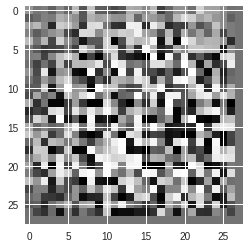

In [13]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [0]:

batch_size=32
z_dimensions=100
tf.reset_default_graph()
sess=tf.Session()

x_placeholder=tf.placeholder("float",shape=[None,28,28,1])
z_placeholder=tf.placeholder(tf.float32,shape=[None,z_dimensions])

In [15]:

Dx=discreminator(x_placeholder)
print(Dx)
Gz=generator(z_placeholder,batch_size,z_dimensions)
Dg=discreminator(Gz,reuse=True)

(?, 32)
Tensor("discreminator/add_3:0", shape=(?, 1), dtype=float32)
(5, 5, 64, 128)
(32, 32)


In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

In [0]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [0]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [0]:
adam = tf.train.AdamOptimizer(learning_rate=0.0001)
trainerD = adam.minimize(d_loss, var_list=d_vars)
adam1= tf.train.AdamOptimizer()
trainerG = adam1.minimize(g_loss, var_list=g_vars)

In [0]:
import time
dLossList=[]
gLossList=[]

In [21]:
sess.run(tf.global_variables_initializer())
batch_size = 32 #Size of image batch to apply at each iteration.
iterations = 50000
startTime=time.time()
for i in range(iterations):
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1]) 
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator
    if i%500==0:
      endTime=time.time()-startTime
      
      print(dLoss,gLoss)
      dLossList.append(dLoss)
      gLossList.append(gLoss)
      startTime=time.time()
      

1.3863058 0.6931555
1.3799713 0.70692325
1.2006121 0.7931341
0.8685546 1.2390535
0.27905685 2.1625326
0.5808341 1.4532187
0.2136699 2.2656696
0.44315237 2.4628205
0.5764203 2.1470704
0.16044092 2.567185
0.5199139 2.0016031
0.38573366 2.79667
0.48793408 2.0692184
0.12350164 2.549585
0.06952568 3.232692
0.053568225 3.5945847
0.23854756 3.6855032
0.074364215 2.785835
0.04334064 3.9669378
0.054563522 4.1556406
0.32782766 4.305545
0.25267142 2.3884587
0.05238682 3.821756
0.041235156 3.8836498
0.037112992 3.9564097
0.43889952 3.013815
0.076489896 3.509067
0.012436413 4.430012
0.026623962 5.0672007
0.023085278 4.1494904
0.04717525 5.2577477
0.010449187 4.839141
0.013938378 5.7135935
0.04044511 3.9530978
0.01214983 4.8855696
0.015517158 6.0386467
0.009317055 6.347269
0.010901169 6.2931356
0.0047860676 7.6311088
0.0029149754 6.1076217
0.010022275 6.9061265
0.0074915336 5.69668
0.025388435 4.8785543
0.12027989 3.3222904
0.31588233 2.7672138
0.5977791 2.9361546
0.10824261 3.202909
0.07870582 4.60

KeyboardInterrupt: ignored

(5, 5, 64, 128)


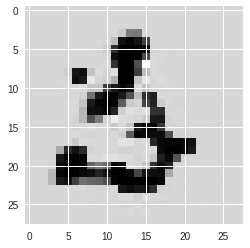

In [22]:

sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.uniform(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')

In [0]:
saver = tf.train.Saver()

from google.colab import files
files.download(sess)

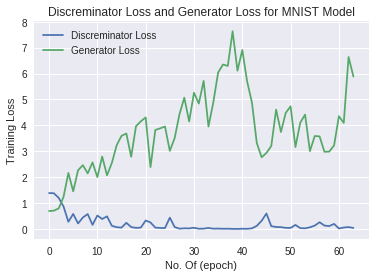

In [27]:
plt.plot(dLossList)
plt.plot(gLossList)
plt.title('Discreminator Loss and Generator Loss for MNIST Model')
plt.xlabel('No. Of (epoch)')
plt.ylabel('Training Loss')
plt.gca().legend(('Discreminator Loss','Generator Loss'))
plt.show()

(?, 32)
(5, 5, 64, 128)
(32, 32)


In [0]:
#use normal distribution, not uniform!!
#AdamOptimizer
#G_loss is positive mean
#max=1000000
#implement epochs (save model after an epoch)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


NameError: ignored

Saving..
Time taken 1.1893539428710938
Saved Model
Saving..
Time taken 468.5000216960907
Saving..
Time taken 467.92356514930725
Saved Model
Saving..
Time taken 475.09435081481934
Saving..
Time taken 478.5287137031555
Saved Model
Saving..
Time taken 475.79258918762207
Saving..
Time taken 475.86081290245056
Saved Model
Saving..
Time taken 470.6700487136841
Saving..
Time taken 471.1506314277649
Saved Model
Saving..
Time taken 474.24436140060425
Saving..
Time taken 473.23919105529785
Saved Model
Saving..
Time taken 475.09070467948914
Saving..
Time taken 472.8668522834778
Saved Model
Saving..
Time taken 469.58861088752747
Saving..
Time taken 473.8233404159546
Saved Model
Saving..
Time taken 476.31962180137634
Saving..
Time taken 477.1801881790161
Saved Model
Saving..
Time taken 475.96649646759033
Saving..
Time taken 477.1893103122711
Saved Model


In [0]:
latent_dim = 512
#Image generator based on tensorflow reimplementation of Progressive GANs[1
# Display multiple images in the same figure.
#The original model has been trained on a GPU for 636,801 steps with batch size 16
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()
  
  


In [0]:
generate = hub.Module("https://tfhub.dev/google/progan-128/1")
images = generate(tf.random_normal([20, 512]))

with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(images)
      
display_images(interpolated_images_out)


